# Classifiers comparison on texts with naive Bayes assumption

In this session of laboratory we compare two models for categorical data probabilistic modeling: 
1. multivariate Bernoulli 
2. multinomial on a dataset 

We adopt a dataset on Twitter messages labelled with emotions (Joy vs Sadness).

The following program shows the loading of the data from a file.

Data are loaded into a matrix X adopting a sparse matrix representation, in order to save space and time.
Sparse matrix representation (in the csr format) represents in three "parallel" arrays the value of the matrix cells that are different from zero and the indices of those matrix cells.
The arrays are called: 
- data
- row
- col

- data[i] stores the value of the matrix cell #i whose indexes are contained in row[i] and col[i] 
- row[i] stores the index of the row in the matrix of the cell #i, 
- col[i] stores the index of the column of the cell #i.


The data file is in csv format.
Any Twitter message has been preprocessed by a Natural Language pipeline which eliminated stop words and substituted the interesting document elements with an integer identifier.  
The interesting document elements might be words, emoji or emoticons. The elements could be repeated in the same document and are uniquely identified in the documents by the same integer number (named "element_id" in the program). This "element_id" number will be used as the index of the column of the data matrix, for the purposes of storage of data.

Each row of the CSV file reports the content of a document (a Twitter message). It is formed as a list of integer number pairs, followed by a string which is the label of the document ("Joy" or "Sadness").
The first number of the pair is the identifier of a document element (the "element_id"); 
the second number of the pair is the count (frequency) of that element in that document.

The dataset has:

tot_n_docs (or rows in the file) =n_rows=11981

n_features (total number of distinct words in the corpus)=11288



The following program reads the data file and loads in a sparse way the matrix using the scipy.sparse library

In [5]:

from numpy import ndarray, zeros
import numpy as np
import scipy
from scipy.sparse import csr_matrix

class_labels = ["Joy","Sadness"]
n_features=11288 # number of columns in the matrix = number of features (distinct elements in the documents)
n_rows=11981 # number rows of the matrix
n_elements=71474 # number of the existing values in the matrix (not empty, to be loaded in the matrix in a sparse way)

#path_training="/Users/meo/Documents/Didattica/Laboratorio-15-16-Jupyter/"
path_training="./datasets/"
file_name="joy_sadness6000.txt"

# declare the row and col arrays with the indexes of the matrix cells (non empty) to be loaded from file
# they are needed because the matrix is sparse and we load in the matrix only the elements which are present
row=np.empty(n_elements, dtype=int)
col=np.empty(n_elements, dtype=int)
data=np.empty(n_elements, dtype=int)

row_n=0 # number of current row to be read and managed
cur_el=0 # position in the three arrays: row, col and data
twitter_labels=[] # list of class labels (target array) of the documents (twitter) that will be read from the input file
twitter_target=[] # list of 0/1 for class labels
with open(path_training + file_name, "r") as fi:
    for line in fi:
        el_list=line.split(',')  # list of integers read from a row of the file
        l=len(el_list)
        last_el=el_list[l-1] # I grab the last element in the list which is the class label
        class_name=last_el.strip() # eliminate the '\n'
        twitter_labels.append(class_name)
        # twitter_labels contains the labels (Joy/Sadness); twitter_target contains 0/1 for the respective labels
        if (class_name==class_labels[0]):
           twitter_target.append(0)
        else:
           twitter_target.append(1)
        i=0 # I start reading all the doc elements from the beginning of the list
        while(i<(l-1)):
            element_id=int(el_list[i]) # identifier of the element in the document equivalent to the column index
            element_id=element_id-1 # the index starts from 0 (the read id starts from 1)
            i=i+1
            value_cell=int(el_list[i]) # make access to the following value in the file which is the count of the element in the documento 
            i=i+1
            row[cur_el]=row_n # load the data in the three arrays: the first two are the row and col indexes; the last one is the matrix cell value
            col[cur_el]=element_id
            data[cur_el]=value_cell
            cur_el=cur_el+1
        row_n=row_n+1
fi.close
# print("final n_row="+str(row))
# loads the matrix by means of the indexes and the values in the three arrays just filled
twitter_data=csr_matrix((data, (row, col)), shape=(n_rows, n_features)).toarray()
print("resulting matrix:")
print(twitter_data)
# print(twitter_labels)
# print(twitter_target)
print(f'Shape of the matrix: {twitter_data.shape} where rows are the tweets and columns are the features\nEach element of the matrix is the count of the word in the tweet')
print(f'Number of "Joy" labels: {twitter_target.count(0)}')
print(f'Number of "Sadness" labels: {twitter_target.count(1)}')

resulting matrix:
[[ 1  1  1 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]
Shape of the matrix: (11981, 11288) where rows are the tweets and columns are the features
Each element of the matrix is the count of the word in the tweet
Number of "Joy" labels: 5988
Number of "Sadness" labels: 5993


Write a program in the following cell that splits the data matrix in training and test set (by random selection) and predicts the class (Joy/Sadness) of the messages on the basis of the words. 
Consider the two possible models:
multivariate Bernoulli and multinomial Bernoulli.
Find the accuracy of the models and test is the observed differences are significant.

In [6]:
# Split the data into a training set and a test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(twitter_data, twitter_target, test_size=0.3, random_state=42)

print(f'Number of training samples: {len(X_train)}')
print(f'Number of test samples: {len(X_test)}')
# check the distribution of the labels in the training set
print(f'Number of "Joy" labels in the training set: {y_train.count(0)}')
print(f'Number of "Sadness" labels in the training set: {y_train.count(1)}')

Number of training samples: 8386
Number of test samples: 3595
Number of "Joy" labels in the training set: 4158
Number of "Sadness" labels in the training set: 4228


In [7]:
# Use a multivariate Bernoulli distribution to model the data
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

bernoulli = BernoulliNB().fit(X_train, y_train)

# Predict the labels of the test set
bernoulli_pred = bernoulli.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, bernoulli_pred)
print(f'Accuracy of the multivariate Bernoulli model: {accuracy:.4f}')
correct = bernoulli_pred == y_test
print(f'Number of correctly classified samples: {correct.sum()}')
print(f'Number of misclassified samples: {len(correct) - correct.sum()}')

Accuracy of the multivariate Bernoulli model: 0.9505
Number of correctly classified samples: 3417
Number of misclassified samples: 178


In [8]:
# Use a multinomial distribution to model the data
from sklearn.naive_bayes import MultinomialNB

multinomial = MultinomialNB().fit(X_train, y_train)

# Predict the labels of the test set
multinomial_pred = multinomial.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, multinomial_pred)
print(f'Accuracy of the multinomial model: {accuracy:.4f}')
correct = multinomial_pred == y_test
print(f'Number of correctly classified samples: {correct.sum()}')
print(f'Number of misclassified samples: {len(correct) - correct.sum()}')

Accuracy of the multinomial model: 0.9469
Number of correctly classified samples: 3404
Number of misclassified samples: 191


In [9]:
# Perform cross-validation folds with both models
from sklearn.model_selection import cross_val_score

bernoulli_scores = cross_val_score(bernoulli, twitter_data, twitter_target, cv=10)
print(f'Accuracy of the multivariate Bernoulli model: {bernoulli_scores.mean():.4f} with standard deviation {bernoulli_scores.std():.4f}')

multinomial_scores = cross_val_score(multinomial, twitter_data, twitter_target, cv=10)
print(f'Accuracy of the multinomial model: {multinomial_scores.mean():.4f} with standard deviation {multinomial_scores.std():.4f}')

Accuracy of the multivariate Bernoulli model: 0.9528 with standard deviation 0.0077
Accuracy of the multinomial model: 0.9507 with standard deviation 0.0074


In [14]:
# Test if the difference between the two models is statistically significant using a t-test
from scipy.stats import ttest_ind

t, p = ttest_ind(bernoulli_scores, multinomial_scores)
print(f'T-test ind results: t={t:.4f}, p={p:.4f}')
# The null hypothesis is that the two samples (multivariate and multinomial) have the same average values
# The t-test quantifies the difference between the arithmetic means of the two samples
# The p-value is the probability of observing more extreme values of the test statistic (t) given that the null hypothesis is true
# If the p-value is larger than a chosen threshold (e.g. 0.05) it indicates that our observation is not so unlikely to have occurred by chance.
# If the p-value is smaller than the threshold, we can reject the null hypothesis and conclude that the two samples are statistically different.
print('The chosen threshold is 0.05')
print(f'Is p-value {p:.4f} smaller than the threshold? {p < 0.05}, so I do not reject the null hypothesis')

T-test ind results: t=0.5866, p=0.5647
The chosen threshold is 0.05
Is p-value 0.5647 smaller than the threshold? False, so I do not reject the null hypothesis


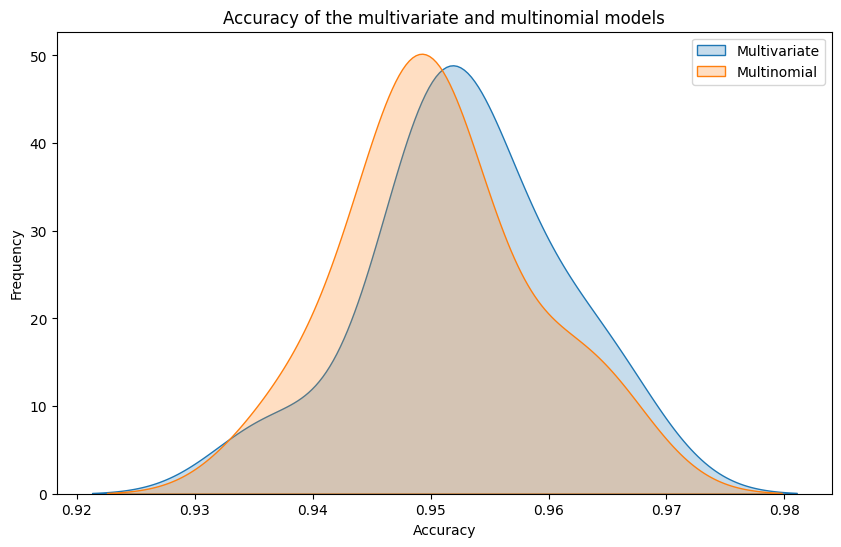

In [15]:
# plot the accuraccy of the multivariate Bernoulli and multinomial models
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.kdeplot(bernoulli_scores, label='Multivariate', fill=True)
sns.kdeplot(multinomial_scores, label='Multinomial', fill=True)
plt.title('Accuracy of the multivariate and multinomial models')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()
